In [1]:
import os
import sys

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F  
import matplotlib 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torch.utils.data
from torch.utils.data import DataLoader

In [44]:
EPSILON = 0.1       # Max perturbation (for L∞ PGD)
ALPHA = 0.01         # Step size per iteration
ATTACK_ITERATIONS = 40
TARGET_LABEL = 1     # Example target label for the targeted attack

# System/Model parameters
sys.path.append("/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/models")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/weights/best_model_retrained.pth"
IQ_FILE_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_2_1m_run3.iq"



In [45]:

from attempt2 import resnet50_1d  # Directly import from attempt2.py
num_classes = 8  # Change this if your model was trained with a different number of classes

# Initialize the model architecture
model = resnet50_1d(num_classes=num_classes).to(DEVICE)

# Load trained weights
print(f"Loading trained model weights from: {MODEL_PATH}")
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()


Loading trained model weights from: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/weights/best_model_retrained.pth


/tmp/ipykernel_225000/2189494409.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)


ResNet1D(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck1D(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
      (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True

In [46]:
class IQDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        sample = torch.from_numpy(sample).float()
        # Normalize data
        magnitude = torch.sqrt(torch.sum(sample**2, dim=1, keepdim=True))
        sample = sample / magnitude

        label_tensors = torch.tensor(label, dtype=torch.long)

        return sample, label_tensors

In [47]:
TRUE_IQ_FILE_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_1_2m_run2.iq"
BATCH_SIZE = 16
WINDOW_SIZE = 10000
HOP_SIZE = 500
START_INDEX = 4800
END_INDEX = 6000

# Initialize and load model
model = resnet50_1d(num_classes=8)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()


fname = os.path.basename(TRUE_IQ_FILE_PATH)
print(f"\nProcessing file: {TRUE_IQ_FILE_PATH}")

# Extract label from filename: Pluto_#_...
try:
    target_label = int(fname.split("_")[1])
except (IndexError, ValueError):
    print(f"  Warning: could not parse label from filename: {fname}")
    

# Load IQ data
data = np.fromfile(TRUE_IQ_FILE_PATH, dtype="float32")
real_part = data[0::2]
imag_part = data[1::2]

test_data_tensors = []
test_label_tensors = []

# Sliding window generation
for x in range(START_INDEX, END_INDEX):
    start = (x + 1) * HOP_SIZE
    end = start + WINDOW_SIZE
    if end > len(real_part): break

    i_window = real_part[start:end]
    q_window = imag_part[start:end]
    combined = np.vstack((i_window, q_window))  # [2, WINDOW_SIZE]
    test_data_tensors.append(combined)
    test_label_tensors.append(target_label)

if not test_data_tensors:
    print(f"Skipping {fname}: not enough valid IQ segments.")
    

# Stack and shuffle
test_data_tensors = np.stack(test_data_tensors, axis=0)
test_label_tensors = np.array(test_label_tensors)
indices = np.random.permutation(len(test_data_tensors))
test_data = test_data_tensors[indices]
test_labels = test_label_tensors[indices]

# Create Dataset + Loader
test_dataset = IQDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluate
correct = 0
total = 0
mismatch_count = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        mismatch_count += (predicted != labels).sum().item()
        correct += (predicted == labels).sum().item()

acc = correct / total * 100
print(f"[{fname}] Accuracy: {acc:.2f}% | Mismatches: {mismatch_count} / {total}")


/tmp/ipykernel_225000/3067821635.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))



Processing file: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_1_2m_run2.iq
[Pluto_1_2m_run2.iq] Accuracy: 96.42% | Mismatches: 43 / 1200


In [48]:
def targeted_pgd_attack(model, x, y, target_label, eps, alpha, num_iter):

    model.eval()
    
    if isinstance(target_label, int):
        target_label = torch.full_like(y, target_label)
    
    x_adv = x.clone().detach().to(DEVICE)
    x_adv.requires_grad = True

    for _ in range(num_iter):
        outputs = model(x_adv)
        
        loss = -nn.CrossEntropyLoss()(outputs, target_label)

        model.zero_grad()
        loss.backward()

        grad = x_adv.grad.data
        x_adv = x_adv.detach() + alpha * grad.sign()

        x_adv = torch.min(torch.max(x_adv, x - eps), x + eps)

        x_adv.requires_grad = True

    return x_adv.detach()

Loading data from: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_2_1m_run3.iq
True label: 2, Target label: 1
Original prediction: 2, Confidence: 1.0000
Adversarial prediction: 1, Confidence: 1.0000
Saved perturbation to Apr9/pluto0_to_target1_noise.iq


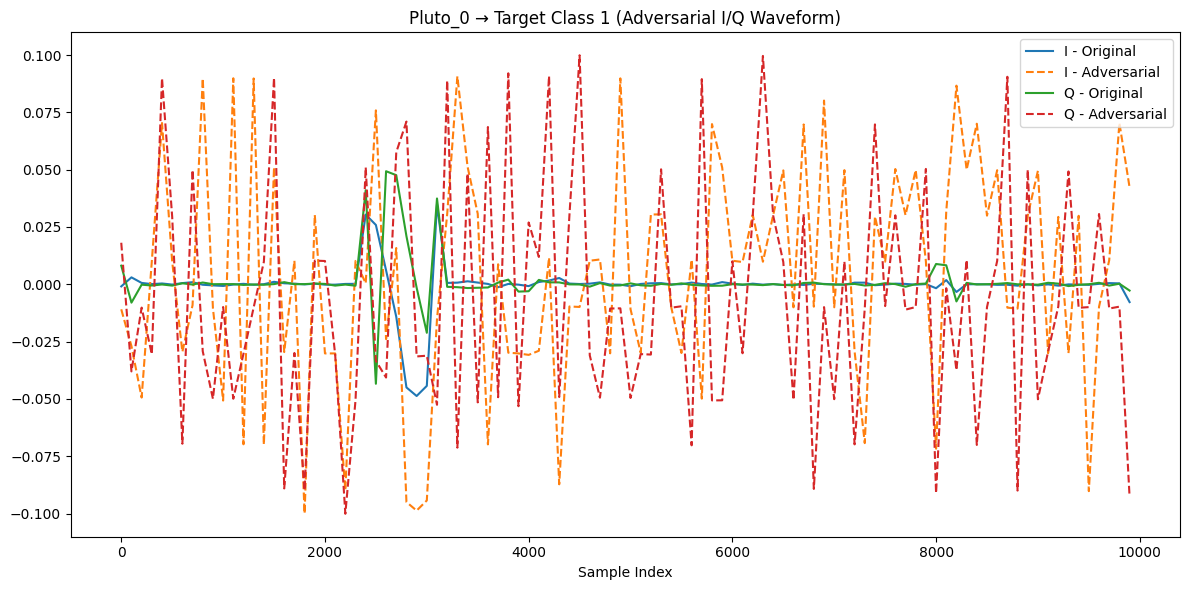

In [49]:
def main():
    print(f"Loading data from: {IQ_FILE_PATH}")

    # Use true label from filename (Pluto_0 → class 0)
    label = int(os.path.basename(IQ_FILE_PATH).split("_")[1])  # This will be 0
    print(f"True label: {label}, Target label: {TARGET_LABEL}")

    # Load and format IQ data
    data = np.fromfile(IQ_FILE_PATH, dtype="float32")
    real = data[0::2]
    imag = data[1::2]

    start = (START_INDEX + 1) * HOP_SIZE
    end = start + WINDOW_SIZE
    i_window = real[start:end]
    q_window = imag[start:end]
    combined = np.vstack((i_window, q_window))  # [2, N]

    # Wrap in Dataset for normalization
    test_dataset = IQDataset([combined], [label])
    data_tensor, label_tensor = test_dataset[0]
    data_tensor = data_tensor.unsqueeze(0).to(DEVICE)
    label_tensor = label_tensor.unsqueeze(0).to(DEVICE)

    # Prediction before attack
    with torch.no_grad():
        logits = model(data_tensor)
        probs = F.softmax(logits, dim=1)
        orig_pred = torch.argmax(probs, dim=1)
        orig_conf = probs.max(dim=1).values

    print(f"Original prediction: {orig_pred.item()}, Confidence: {orig_conf.item():.4f}")

    # PGD attack targeting label 1
    x_adv = targeted_pgd_attack(
        model=model,
        x=data_tensor,
        y=label_tensor,
        target_label=TARGET_LABEL,
        eps=EPSILON,
        alpha=ALPHA,
        num_iter=ATTACK_ITERATIONS
    )

    with torch.no_grad():
        logits_adv = model(x_adv)
        probs_adv = F.softmax(logits_adv, dim=1)
        adv_pred = torch.argmax(probs_adv, dim=1)
        adv_conf = probs_adv.max(dim=1).values

    print(f"Adversarial prediction: {adv_pred.item()}, Confidence: {adv_conf.item():.4f}")

    # Save perturbation
    original_np = data_tensor.squeeze().cpu().numpy()
    adv_np = x_adv.squeeze().cpu().numpy()
    I_diff = adv_np[0] - original_np[0]
    Q_diff = adv_np[1] - original_np[1]

    interleaved = np.empty(I_diff.size + Q_diff.size, dtype=np.float32)
    interleaved[0::2] = I_diff
    interleaved[1::2] = Q_diff

    save_path = "Apr9/pluto0_to_target1_noise.iq"
    interleaved.tofile(save_path)
    print(f"Saved perturbation to {save_path}")

    # Plot
    time = np.arange(original_np.shape[1])
    ds = 100
    plt.figure(figsize=(12, 6))
    plt.plot(time[::ds], original_np[0][::ds], label="I - Original")
    plt.plot(time[::ds], adv_np[0][::ds], '--', label="I - Adversarial")
    plt.plot(time[::ds], original_np[1][::ds], label="Q - Original")
    plt.plot(time[::ds], adv_np[1][::ds], '--', label="Q - Adversarial")
    plt.legend()
    plt.title("Pluto_0 → Target Class 1 (Adversarial I/Q Waveform)")
    plt.xlabel("Sample Index")
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    main()


Test the newly generated sample

In [50]:
def test_saved_noise_sample():
    save_path = "Apr9/pluto0_to_target1_noise.iq"
    print(f"\nTesting saved perturbation from: {save_path}")

    # Recompute label from filename
    label = int(os.path.basename(IQ_FILE_PATH).split("_")[1])  # e.g., Pluto_0 → 0

    # Load the original IQ data again
    data = np.fromfile(IQ_FILE_PATH, dtype="float32")
    real = data[0::2]
    imag = data[1::2]

    start = (START_INDEX + 1) * HOP_SIZE
    end = start + WINDOW_SIZE
    i_window = real[start:end]
    q_window = imag[start:end]

    # Load the saved noise
    noise = np.fromfile(save_path, dtype="float32")
    I_diff = noise[0::2]
    Q_diff = noise[1::2]

    # Apply the perturbation
    perturbed = np.vstack((i_window + I_diff, q_window + Q_diff))  # Shape [2, N]

    # Wrap in dataset and tensor
    test_dataset = IQDataset([perturbed], [label])
    data_tensor, _ = test_dataset[0]
    data_tensor = data_tensor.unsqueeze(0).to(DEVICE)

    # Run through the model
    with torch.no_grad():
        logits = model(data_tensor)
        probs = F.softmax(logits, dim=1)
        pred = torch.argmax(probs, dim=1)
        conf = probs.max(dim=1).values

    print(f"Prediction on saved noise sample: {pred.item()}, Confidence: {conf.item():.4f}")

test_saved_noise_sample()


Testing saved perturbation from: Apr9/pluto0_to_target1_noise.iq
Prediction on saved noise sample: 1, Confidence: 1.0000


Create PGD

In [51]:
def generate_eot_pgd_noise():
    print(f"Loading data from: {IQ_FILE_PATH}")
    label = int(os.path.basename(IQ_FILE_PATH).split("_")[1])
    print(f"True label: {label}, Target label: {TARGET_LABEL}")

    # Load IQ data
    data = np.fromfile(IQ_FILE_PATH, dtype="float32")
    real = data[0::2]
    imag = data[1::2]
    start = (START_INDEX + 1) * HOP_SIZE
    end = start + WINDOW_SIZE
    i_window = real[start:end]
    q_window = imag[start:end]
    combined = np.vstack((i_window, q_window))  # [2, N]

    # Format into dataset
    test_dataset = IQDataset([combined], [label])
    data_tensor, label_tensor = test_dataset[0]
    data_tensor = data_tensor.unsqueeze(0).to(DEVICE)
    label_tensor = label_tensor.unsqueeze(0).to(DEVICE)
    min_distance=.0
    max_distance=9.0
    if min_distance >= 3.0:
        EPSILON = 0.6
        ALPHA = 0.021
        ATTACK_ITERATIONS = 100

    # EoT PGD attack
    x_adv = targeted_eot_pgd_attack(
        model=model,
        x=data_tensor,
        y=label_tensor,
        target_label=TARGET_LABEL,
        eps=EPSILON,
        alpha=ALPHA,
        num_iter=ATTACK_ITERATIONS,
        num_samples=10,
        min_distance=min_distance,
        max_distance=max_distance,
        noise_std=0.01
    )

    # Save perturbation only
    original_np = data_tensor.squeeze().cpu().numpy()
    adv_np = x_adv.squeeze().detach().cpu().numpy()

    I_diff = adv_np[0] - original_np[0]
    Q_diff = adv_np[1] - original_np[1]

    interleaved = np.empty(I_diff.size + Q_diff.size, dtype=np.float32)
    interleaved[0::2] = I_diff
    interleaved[1::2] = Q_diff

    save_path = "high_dist_eot_pluto0_to_target1_noise.iq"
    interleaved.tofile(save_path)
    print(f"Saved EoT PGD noise to {save_path}")

    # --- Evaluate by re-applying noise to original signal ---
    print(f"\nTesting saved EoT noise from: {save_path}")
    noise = np.fromfile(save_path, dtype=np.float32)
    I_noise = noise[0::2]
    Q_noise = noise[1::2]

    perturbed = np.vstack((i_window + I_noise, q_window + Q_noise))
    test_dataset = IQDataset([perturbed], [label])
    data_tensor_adv, _ = test_dataset[0]
    data_tensor_adv = data_tensor_adv.unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        logits_adv = model(data_tensor_adv)
        probs_adv = F.softmax(logits_adv, dim=1)
        print(f"Full softmax probabilities:\n{probs_adv.cpu().numpy()}")

        adv_pred = torch.argmax(probs_adv, dim=1)
        adv_conf = probs_adv.max(dim=1).values

    print(f"Prediction on saved noise sample: {adv_pred.item()}, Confidence: {adv_conf.item():.4f}")

if __name__ == "__main__":
    generate_eot_pgd_noise()


Loading data from: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_2_1m_run3.iq
True label: 2, Target label: 1


UnboundLocalError: cannot access local variable 'EPSILON' where it is not associated with a value

In [17]:
Test = "pluto0_to_target1_noise.iq"
WINDOW_SIZE = 10000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = resnet50_1d(num_classes=8)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Get filename
fname = os.path.basename(Test)
print(f"\nProcessing file: {Test}")

# Manually assign label since filename doesn't follow Pluto_# format
target_label = 0  # or whatever the expected true label is

# Load IQ data
data = np.fromfile(Test, dtype="float32")
real_part = data[0::2]
imag_part = data[1::2]

# Check file length
start = 0
end = start + WINDOW_SIZE
if end > len(real_part):
    raise ValueError(f"Not enough samples in file: required {end}, got {len(real_part)}")

# Extract 1 window
i_window = real_part[start:end]
q_window = imag_part[start:end]
combined = np.vstack((i_window, q_window))  # shape: [2, WINDOW_SIZE]

# Create dataset and dataloader
test_dataset = IQDataset([combined], [target_label])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Evaluate
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(DEVICE)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        pred = torch.argmax(probs, dim=1)
        conf = probs.max(dim=1).values
        print(f"[{fname}] Prediction: {pred.item()}, Confidence: {conf.item():.4f}")


Processing file: pluto0_to_target1_noise.iq
[pluto0_to_target1_noise.iq] Prediction: 3, Confidence: 0.8952


/tmp/ipykernel_225000/3723694938.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
